In [1]:
from itertools import permutations
from sys import maxsize
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

# Travelling Salesman Problem

(Source: Bertsekas, 2023, p. 135)<br>
The following work problem is inspired by the source with some modifications.

## Essential reads:
- A course in reinforcement learning, Pages 21 - 26
- Lecture note: Topics in Reinforcement Learning: Lessons from AlphaZero for (Sub)Optimal Control and Discrete Optimization Lecture 1

## Problem
Consider a 5-city travelling salesman problem which involves cities A, B, C, D and E and with the following intercity travel cost matrix

<style>
table {
    border-collapse: collapse;
}

th, td {
    border: 1px solid black;
    padding: 8px;
    text-align: center; /* Center align text */
}

th:first-child,
td:first-child {
    background-color: transparent; /* Unshaded first column */
    font-weight: bold; /* Make text in first column bold */
}

tr:first-child th {
    background-color: transparent; /* Unshaded first row */
}
</style>

|       | A | B | C | D | E |
|-------|----------|----------|----------|----------|----------|
| A | 0   | 5   | 1   | 20 | 10 |
| B | 20   | 0   | 1   | 4 | 10 |
| C | 1   | 20   | 0   | 3 | 10 |
| D | 18   | 4   | 3   | 0 | 10 |
| E | 30   | 10   | 0   | 10 | 0 |


Our objectives are as follows:
1. Starting (and ending) at City A, create a program that helps identify the optimal cost-to-go $J^*(x_0)$ and the corresponding optimal control sequence
2. Apply the nearest neighbour heuristic to find the base heuristic and the associated cost-to-go $\tilde{J}(x_0)$
3. Continue the rollout using the nearest neighbour heuristic with increasing step $k$, and plot the suboptimal cost-to-go with against step $k$. Identify at which iteration did we converge to the optimal solution.
4. Try starting your journey from other cities, and determine the optimal "cost-to-go"s for each different start points. Are the results within your expectation?

In [2]:
# data class that maps each city to the corresponding index
class City(Enum):
    A = 0
    B = 1
    C = 2
    D = 3
    E = 4

# Cost matrix as provided
cost_matrix =\
    np.array(
        [
            [0,5,1,20,10],
            [20,0,1,4,10],
            [1,20,0,3,10],
            [18,4,3,0,10],
            [30,10,0,10,0]
        ]
    )

## Obtaining the optimal cost-to-go $J*(x_0)$ and the optimal control sequence

In [3]:
def optimal_solution(source, verbose = True):
    """
    Finds the optimal solution for a given source city and cost matrix and returns the optimal cost and travel route.

    Args:
        source (str): The source city.
        verbose (bool, optional): Controls whether to display output information (default is True).

    Returns:
        tuple: A tuple containing the optimal cost and the optimal travel route.

    """

    # Obtain the index of the source city
    start_end = City[source].value

    # Create the vertex, this includes all the cities excluding the source city
    vertex = [city.value for city in City if city.value != start_end]

    # Find the possible paths through permutations
    possible_paths = permutations(vertex)
    
    # Initiate the optimal route with the source city as the starting point
    optimal_route = [source]

    # Initiate the optimal_cost_to_go with the largest possible value
    optimal_cost_to_go = maxsize

    # Initiate the optimal_control_sequence with an empty list
    optimal_control_sequence = []

    for path in possible_paths:
        # Iterate through all possible paths

        current_cost_to_go = 0
        current_state = start_end

        for next_state in path:
            # Calculate and add on the increment cost
            current_cost_to_go += cost_matrix[current_state, next_state]
            # traverse through the next state in the path
            current_state = next_state

        # Close the loop by adding the cost of going from the last state to the start point
        current_cost_to_go += cost_matrix[current_state, start_end]

        # Update optimal_cost_to_go
        optimal_cost_to_go =\
            min(
                optimal_cost_to_go,
                current_cost_to_go
            )
        
        # Update optimal_control_sequence
        optimal_control_sequence =\
        (
            optimal_control_sequence
            if optimal_cost_to_go < current_cost_to_go
            else path
        )

    # Convert optimal_control_sequence into the optimal_route (from index to name)
    optimal_route +=\
    (
        [City(i).name 
         for i 
         in optimal_control_sequence]
    )

    # complete the optimal route
    optimal_route.append(source)

    if verbose:
        # Print results
        print(f'Optimal cost: {optimal_cost_to_go}')
        print(f'Optimal travel route: {optimal_route}')

    return optimal_cost_to_go, optimal_route
    

In [4]:
start_from_A = optimal_solution('A')

Optimal cost: 20
Optimal travel route: ['A', 'B', 'D', 'E', 'C', 'A']


## Applying Nearest Neighbour Heuristic to obtain the base heuristic ($T_0$)

<b>Description of algorithm</b>:<br>

Starting from city `A`:
1. Consider the costs incurred travelling into the next city (for this case, `B`, `C`, `D` and `E`)
2. Based on the costs, choose the path with the least cost, i.e. `AC`
3. Now, being at city `C`, repeat step 1 and 2 until we've covered all the possible cities exactly once
4. End the tour with the start point, i.e. `A`

Our expected base heuristic is:
- `ACDBEA` with a cost of 48

In [5]:
def NN_base_heuristic(source, verbose = True):
    """
    Applies a nearest neighbor to find the base heuristic starting from the given source city.

    Args:
        source (str): The name of the source city.
        verbose (bool, optional): Controls whether to display output information (default is True).

    Returns:
        tuple: A tuple containing the suboptimal cost and the suboptimal travel route.
    """

    # Initiate the suboptimal_route with the starting city
    suboptimal_route = [source]
    # Obtain the index of the starting city
    start_end = City[source].value
    
    # Create the vertex, this includes all the cities excluding the source city
    vertex = [city.value for city in City if city.value != start_end]
    
    def nearest_neighbour(current_state, vertex):
        """
        Finds the nearest neighbor to the given current_state from the remaining vertices.

        Args:
            current_state (int): The current city index.
            vertex (list): List of remaining cities to travel to.

        Returns:
            tuple: A tuple containing the cost and the sequence of cities in the suboptimal route.
        """
        # Initialize optimal incremental cost and next states
        optimal_incremental_cost = maxsize
        optimal_next_state = None

        for next_state in vertex:
            # iterate through all possible next step
            if cost_matrix[current_state, next_state] < optimal_incremental_cost:
                # update optimal next state with the nearest neighbour
                optimal_next_state = next_state
                # update the optimal_increment_cost with the cost to nearest neighbour
                optimal_incremental_cost = cost_matrix[current_state, next_state]
        
        # Update vertex to remove nearest neighbour
        vertex.remove(optimal_next_state)

        if vertex:
            # If there are more cities remaining
            # Run nearest_neighbour again
            next_stage_cost, future_states = nearest_neighbour(optimal_next_state, vertex)
            # return suboptimal_cost_to_go from current state to end state, and the tail suboptimal sequence
            return optimal_incremental_cost + next_stage_cost, [optimal_next_state] + future_states
        
        else:
            # return the incremental_cost and the last city before returning to start point
            return optimal_incremental_cost, [optimal_next_state]
        
    
    suboptimal_cost, suboptimal_sequence =\
    (
        nearest_neighbour(start_end, vertex)
    )

    # Complete the suboptimal cost calculation with the cost going back to start point
    suboptimal_cost += cost_matrix[suboptimal_sequence[-1], start_end]

    # Convert suboptimal_sequence into suboptimal_route with city names
    suboptimal_route +=\
    (
        [City(i).name 
         for i 
         in suboptimal_sequence]
    )

    # Complete suboptimal_route by adding back the start point
    suboptimal_route.append(source)

    if verbose:
        # print results
        print(f'Sub-Optimal cost: {suboptimal_cost}')
        print(f'Sub-Optimal travel route: {suboptimal_route}')

    return suboptimal_cost, suboptimal_route
        

    

In [6]:
base_heuristic = NN_base_heuristic("A")

Sub-Optimal cost: 48
Sub-Optimal travel route: ['A', 'C', 'D', 'B', 'E', 'A']


## Apply rollout with one-step lookahead minimization

<b>Description of algorithm (one-step)</b>:<br>

Starting at city `A`, 
1. Consider the options of moving to the next cities `B`, `C`, `D` and `E`; we denote these as `AB`, `AC`, `AD` and `AE` respectively
2. Apply the nearest neighbour heuristic; the difference is that instead of applying it at the start point, we apply it at the second city
3. The end result is 4 different sets of heuristics; we choose the one with the least cost as our heuristic $T_1$ and associated starting states (i.e.`AE`)
4. With the associated starting states, we repeat steps 1 - 3, until we are only left with the last step (here there is no more permutation to consider)
5. Complete the calculation by adding the cost of going back to the starting point

Our expected suboptimal solution is:
- `AECDBA` with a cost of 37


In [7]:
def NN_one_step_rollout(source, verbose = True):
    """
    Performs a one-step rollout using a nearest neighbor approach to find a suboptimal route from the given source city.

    Args:
        source (int): The identifier of the source city.
        verbose (bool, optional): Controls whether to display output information (default is True).

    Returns:
        tuple: A tuple containing the suboptimal travel route and its cost.
    """

    def nearest_neighbour(current_state, vertex):
        """
        Finds the nearest neighbor to the given current_state from the remaining vertices.

        Args:
            current_state: The current city identifier.
            vertex (list): List of remaining city identifiers.

        Returns:
            tuple: A tuple containing the cost and the sequence of cities in the suboptimal route.
        """
        # Initialize optimal incremental cost and next states
        optimal_incremental_cost = maxsize
        optimal_next_state = None

        for next_state in vertex:
            # iterate through all possible next step
            if cost_matrix[current_state, next_state] < optimal_incremental_cost:
                # update optimal next state with the nearest neighbour
                optimal_next_state = next_state
                # update the optimal_increment_cost with the cost to nearest neighbour
                optimal_incremental_cost = cost_matrix[current_state, next_state]
        
        # Update vertex to remove nearest neighbour
        vertex.remove(optimal_next_state)

        if vertex:
            # If there are more cities remaining
            # Run nearest_neighbour again
            next_stage_cost, future_states = nearest_neighbour(optimal_next_state, vertex)
            # return suboptimal_cost_to_go from current state to end state, and the tail suboptimal sequence
            return optimal_incremental_cost + next_stage_cost, [optimal_next_state] + future_states
        
        else:
            # return the incremental_cost and the last city before returning to start point
            return optimal_incremental_cost, [optimal_next_state]
    
    def rollout(vertex, curr_state, curr_cost, curr_sequence):
        """
        Conducts a rollout from the current state considering the remaining vertices.

        Args:
            vertex (list): List of remaining city identifiers.
            curr_state: The current city identifier.
            curr_cost: The current cost of the route.
            curr_sequence (list): The current sequence of cities in the route.

        Returns:
            tuple: A tuple containing the suboptimal route and its cost.
        """
        
        i = len(curr_sequence)
        
        # Initialize current best cost to be a high value
        best_suboptimal_cost = maxsize
        best_suboptimal_sequence = None

        for city in vertex:
            # look into all the cities in the remaining vertices

            # calculate the cost if we were to go forward with the given city
            suboptimal_cost = curr_cost + cost_matrix[curr_state, city]
            suboptimal_sequence = curr_sequence + [city]

            # Update sub_vertex by removing the city which we travelled into
            sub_vertex = vertex.copy()
            sub_vertex.remove(city)

            tail_cost, tail_sequence =\
            (
                # run nearest neighbour heuristic for the current route
                nearest_neighbour(city, sub_vertex)
            )
            
            # Update the cost of the current route
            suboptimal_cost += tail_cost + cost_matrix[tail_sequence[-1], start_end]
            suboptimal_sequence += tail_sequence + [start_end]

            if suboptimal_cost < best_suboptimal_cost:
                # Update the current cost as the best suboptimal cost, if cost is reduced
                best_suboptimal_cost = suboptimal_cost
                best_suboptimal_sequence = suboptimal_sequence

        # New sequence is the current sequence and the next one step based on the most optimal route by NN heuristic
        new_subsequence = best_suboptimal_sequence[:i+1]
        
        new_state = best_suboptimal_sequence[i]
        new_subcost =\
        (
            sum(
                cost_matrix[new_subsequence[i-1], new_subsequence[i]] 
                for i in range(1, len(new_subsequence))
                )
        )

        # Update the new vertex by removing the next one step
        new_vertex = vertex.copy()
        new_vertex.remove(new_subsequence[-1])
            
        if len(new_vertex) > 1:
            # If there are more than one city left in new vertex, roll out again

            return rollout(new_vertex, new_state, new_subcost, new_subsequence)

        else:
            return best_suboptimal_sequence, best_suboptimal_cost

    # Main operation begins here
    start_end = City[source].value
    vertex = [city.value for city in City if city.value != start_end]
    current_cost = 0
    current_sequence = [start_end]
    
    best_suboptimal_sequence, best_suboptimal_cost = rollout(vertex, start_end, current_cost, current_sequence)

    best_suboptimal_route =\
    (
            [City(i).name 
                for i 
                in best_suboptimal_sequence]
        )
    
    if verbose:
        print(f'Sub-Optimal cost: {best_suboptimal_cost}')
        print(f'Sub-Optimal travel route: {best_suboptimal_route}')

    return best_suboptimal_route, best_suboptimal_cost

        

In [8]:
onestep_rollout = NN_one_step_rollout('A')

Sub-Optimal cost: 37
Sub-Optimal travel route: ['A', 'E', 'C', 'D', 'B', 'A']


## Apply rollout with k-step lookahead minimization

<b>Description of algorithm (k-step)</b>:<br>

Similar to the one-step algorithm, instead of considering only moving to the next cities in step one, we consider two cities at once. So we need to run a permutation.<br>

Example: starting from `A`, we need to consider: `ABC`, `ACB`, `ABD`, `ADB`, ...<br>. This gives us $\frac{N!}{(N-k)!}$ sets of heuristics (N is the number of cities excluding start point).<br>

Once we have found the heuristic with the least cost, we move on by <b>only one</b> city, i.e. if `ABD` gives the heuristic with the best suboptimal cost, we move toward city `B`. We then continue the routine until we covered all the cities.

In [9]:
def NN_k_step_rollout(source, k, verbose = True):
    """
    Performs a k-step rollout using a nearest neighbor approach to find a suboptimal route from the given source city.
    k has to be smaller than the number of cities to be travelled to, excluding the starting point.

    Args:
        source (int): The identifier of the source city.
        k (int): The numebr of lookahead steps
        verbose (bool, optional): Controls whether to display output information (default is True).

    Returns:
        tuple: A tuple containing the suboptimal travel route and its cost.
    """
    def nearest_neighbour(current_state, vertex):
        """
        Finds the nearest neighbor to the given current_state from the remaining vertices.

        Args:
            current_state: The current city identifier.
            vertex (list): List of remaining city identifiers.

        Returns:
            tuple: A tuple containing the cost and the sequence of cities in the suboptimal route.
        """
        # Initialize optimal incremental cost and next states
        optimal_incremental_cost = maxsize
        optimal_next_state = None

        for next_state in vertex:
            # iterate through all possible next step
            if cost_matrix[current_state, next_state] < optimal_incremental_cost:
                # update optimal next state with the nearest neighbour
                optimal_next_state = next_state
                # update the optimal_increment_cost with the cost to nearest neighbour
                optimal_incremental_cost = cost_matrix[current_state, next_state]
        
        # Update vertex to remove nearest neighbour
        vertex.remove(optimal_next_state)

        if vertex:
            # If there are more cities remaining
            # Run nearest_neighbour again
            next_stage_cost, future_states = nearest_neighbour(optimal_next_state, vertex)
            # return suboptimal_cost_to_go from current state to end state, and the tail suboptimal sequence
            return optimal_incremental_cost + next_stage_cost, [optimal_next_state] + future_states
        
        else:
            # return the incremental_cost and the last city before returning to start point
            return optimal_incremental_cost, [optimal_next_state]
        

    def rollout(vertex, k, curr_state, curr_cost, curr_sequence):
        """
        Conducts a rollout from the current state considering the remaining vertices.

        Args:
            vertex (list): List of remaining city identifiers.
            k (int): The number of lookahead steps
            curr_state: The current city identifier.
            curr_cost: The current cost of the route.
            curr_sequence (list): The current sequence of cities in the route.

        Returns:
            tuple: A tuple containing the suboptimal route and its cost.
        """

        i = len(curr_sequence)
        
        # Initialize current best cost to be a high value
        best_suboptimal_cost = maxsize
        best_suboptimal_sequence = None

        for cities in permutations(vertex,k):
            # look into all possible k-step permutations

            # calculate the cost if we were to go forward with the given permutation
            suboptimal_cost =\
            (
                curr_cost
                + cost_matrix[curr_state, cities[0]] 
            )
            # if k > 1, we need to continue travel outwards
            if k > 1:
                suboptimal_cost +=\
                    sum(cost_matrix[cities[i], cities[i+1]]
                      for i in range(k-1))
                
            suboptimal_sequence = curr_sequence + [city for city in cities]

            sub_vertex = vertex.copy()
            
            # Update sub_vertex by removing all cities in the current permutation
            for city in cities:
                sub_vertex.remove(city)

            tail_cost, tail_sequence =\
            (
                # run nearest neighbour heuristic for the current route
                nearest_neighbour(cities[-1], sub_vertex)
            )
            
            # Update the cost of the current route
            suboptimal_cost += tail_cost + cost_matrix[tail_sequence[-1], start_end]
            suboptimal_sequence += tail_sequence + [start_end]

            if suboptimal_cost < best_suboptimal_cost:
                # Update the current cost as the best suboptimal cost, if cost is reduced
                best_suboptimal_cost = suboptimal_cost
                best_suboptimal_sequence = suboptimal_sequence

        # New sequence is the current sequence and the next one step based on the most optimal route by NN heuristic
        new_subsequence = best_suboptimal_sequence[:i+1]
        
        new_state = best_suboptimal_sequence[i]
        new_subcost =\
        (
            sum(
                cost_matrix[new_subsequence[i-1], new_subsequence[i]] 
                for i in range(1, len(new_subsequence))
                )
        )

        # Update the new vertex by removing the next one step
        new_vertex = vertex.copy()
        new_vertex.remove(new_subsequence[-1])
            
        if len(new_vertex) > k:
            # If there are more than k cities left in new vertex, roll out again
            return rollout(new_vertex, k, new_state, new_subcost, new_subsequence)

        else:
            return best_suboptimal_sequence, best_suboptimal_cost

    # Main operation begins here
    start_end = City[source].value
    vertex = [city.value for city in City if city.value != start_end]

    if k >= len(vertex):
        raise ValueError(f'"k" must be smaller than the number of cities excluding the source! k provided: {k}.')

    current_cost = 0
    current_sequence = [start_end]

    best_suboptimal_sequence, best_suboptimal_cost = rollout(vertex, k, start_end, current_cost, current_sequence)

    best_suboptimal_route =\
    (
            [City(i).name 
                for i 
                in best_suboptimal_sequence]
        )
    
    if verbose:
        print(f'Sub-Optimal cost: {best_suboptimal_cost}')
        print(f'Sub-Optimal travel route: {best_suboptimal_route}')

    return best_suboptimal_route, best_suboptimal_cost

        

In [10]:
costs = [base_heuristic[0]]

for i in range(1,4):
    kstep_rollout = NN_k_step_rollout('A', i, verbose = False)
    costs.append(kstep_rollout[1])



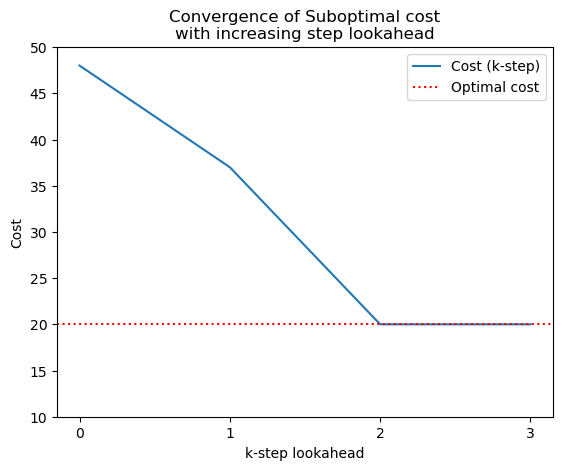

In [11]:
x = list(range(4))
plt.plot(x, costs)
plt.axhline(y = start_from_A[0], c = 'r', ls = ':')
plt.xticks(x)
plt.ylim(10,50)
plt.legend(['Cost (k-step)', 'Optimal cost'])
plt.title('Convergence of Suboptimal cost\nwith increasing step lookahead')
plt.ylabel('Cost')
plt.xlabel('k-step lookahead')
plt.show()

## Optimal "cost-to-go"s for each different start point

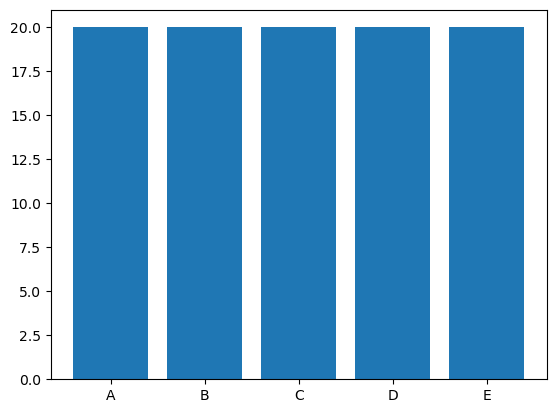

In [12]:
optimal_costs = []
start_points = ['A', 'B', 'C', 'D', 'E']
for start_point in start_points:
    optimal_costs.append(optimal_solution(start_point, verbose = False)[0])


plt.bar(start_points, optimal_costs)
plt.show()

The optimal cost is the same regardless of the starting point! This is because this is a round trip, where you begin does not matter.

# References

Bertsekas, D. P. (2023). A course in reinforcement learning (p. 135). Athena Scientific.

Bertsekas, D. P. (2022). Lecture 1: Course Introduction and Overview. In Topics in Reinforcement Learning: Lessons from AlphaZero for (Sub)Optimal Control and Discrete Optimization [Lecture notes]. Arizona State University, CSE 691, Spring 2022. Retrieved from http://web.mit.edu/dimitrib/www/RLbook.html